In [157]:
import sys
sys.path.append('/global/homes/p/portmanm/timedomain/gwtarget/')

from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack, unique, setdiff
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle
from astropy.time import Time

from gw_skymap import plot_mollmap, compute_quantiles, compute_contours #plot_cartmap
from desitarget import io, cuts

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd
import glob
import sys

import sqlite3
import os

# From https://github.com/desihub/timedomain/blob/master/gwtarget/gw_skymap.py
# Because I was having trouble importing again

def compute_quantiles(proportions, samples):
    """Get quantiles of HEALPix probability map.

    Parameters:
    -----------
    proportions: list
        list of containment level to make contours for.
        E.g [0.68,0.9]
    samples: array
        array of values read in from healpix map
        E.g samples = hp.read_map(file)

    Returns:
    --------
    levels: list
        List of map values corresponding to a given containment level.
    """
    levels = []
    sorted_samples = list(reversed(list(sorted(samples))))
    nside = hp.pixelfunc.get_nside(samples)
    sample_points = np.array(hp.pix2ang(nside,np.arange(len(samples)))).T
    for proportion in proportions:
        level_index = (np.cumsum(sorted_samples) > proportion).tolist().index(True)
        level = (sorted_samples[level_index] + (sorted_samples[level_index+1] if level_index+1 < len(samples) else 0)) / 2.0
        levels.append(level)
    return levels

In [141]:
# From decam_TAMU_ledgermaker.ipynb - https://github.com/desihub/timedomain/blob/master/too_ledgers/decam_TAMU_ledgermaker.ipynb
# Thanks Antonella!

def write_too_ledger(filename, too_table, checker, overwrite=False, verbose=False, tabformat='TAMU'):
    """Write ToO ledger in the ECSV format specified by Adam Meyers.
    These can be passed to fiberassign for secondary targeting.
    
    Parameters
    ----------
    filename : str
        Output filename of the ledger (can be an absolute path).
    too_table : pandas.DataFrame
        Table of ToO data, using DECam format.
    checker : str
        Initials of individual(s) who have verified the ToO list.
    overwrite : bool
        If True, overwrite the output file.
    verbose : bool
        If True, 
    """
    mode = 'w' if overwrite else 'a'
    if verbose:
        mode = mode + '+'
    
    with open(filename, mode) as outf:
        if overwrite:
            outf.write("""# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID\n""")
            
        today = Time.now()
        datedict = {}
        reporting = ['DESIRT','DDF','ALERCE']
        
        if tabformat=='TAMU':
            for i in range(too_table.shape[0]):

                row=too_table.iloc[i]           
                coord = SkyCoord(ra=row['RA-OBJECT'], dec=row['DEC-OBJECT'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['Discovery-Time'], scale='utc')

                mag  = row['Discovery-Magnitude']
                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'DESIRT'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
                
        if tabformat=='ddf':
            for i in range(too_table.shape[0]):

                row=too_table[i]           
                coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = today.mjd #Do not have discovery time so using today

                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc) 
                reporter = 'DDF'
                reporting_id=2
                mjd_exp = 100*mjd_disc + reporting_id
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc, t_disc+14, too_id))
                
        if tabformat=='ALERCE':
            for i in range(too_table.shape[0]):

                row = too_table.iloc[i]           
                coord = SkyCoord(ra=row['meanra'], dec=row['meandec'], unit=(u.degree, u.degree))
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['lastmjd'], format = 'mjd')

                #mag  = row['Discovery-Magnitude']
                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'ALERCE'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                    
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
    
        if verbose:
            outf.seek(0)
            for line in outf:
                print(line.strip())
                
    return None

In [3]:
# Borrowed from gw_skymap.py to be modified

def plot_cartmap(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')

    _h, _l = ax.get_legend_handles_labels()

#     # Add DESI tile drawings, specified by central RA, Dec.
#     if tile_ra is not None and tile_dec is not None:
#         for _ra_c, _dec_c in zip(tile_ra, tile_dec):
#             circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
#             ax.add_artist(circ)

#         _h.append(circ)
#         _l.append('DESI FOV')

    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5) # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

In [4]:
# From ALeRCE_ledgermaker https://github.com/alercebroker/alerce_client
# I have had trouble importing this before so here it goes
# Now modified ***
import requests
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import pandas as pd
from alerce.core import Alerce
from alerce.exceptions import APIError

alerce_client = Alerce()

def access_alerts(lastmjd_in=None, ra_in = None, dec_in = None, search_radius = None, classifier='stamp_classifier', class_names=['SN', 'AGN']):
    if type(class_names) is not list:
        raise TypeError('Argument `class_names` must be a list.')
        
    dataframes = []
    if not lastmjd_in:
        date_range = 60
        lastmjd_in = Time.now().mjd - 60
        print('Defaulting to a lastmjd range of', str(date_range), 'days before today.')
        
    for class_name in class_names:
        data = alerce_client.query_objects(classifier=classifier,
                                           class_name=class_name, 
                                           order_by='oid',
                                           order_mode='DESC',
                                           page_size=5000,
                                           lastmjd=lastmjd_in,
                                           ra=ra_in,
                                           dec=dec_in,
                                           radius=search_radius,
                                           format='pandas')
        
        #if lastmjd is not None:
        #    select = data['lastmjd'] >= lastmjd
        #    data = data[select]
            
        dataframes.append(data)
    
    return pd.concat(dataframes).sort_values(by='lastmjd')

In [5]:
def read_gwfile(filepath: str, hdu_num = 1):
    
    properties = {}
    
    try:
        with fits.open(filepath) as hdu1:
    
            hdr = hdu1[hdu_num].header
        
            properties["mjd"] = hdr["MJD-OBS"]
            properties["nside"] = hdr["NSIDE"]
            properties["nest"] = True if hdr["ORDERING"] == "NESTED" else False #save myself some time here
            
            data_table = Table(hdu1[hdu_num].data) #columns
            properties["prob"] = data_table["PROB"].data
        
            #targ_id = data_table['TARGETID']
            #targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            #targ_dec = data_table['TARGET_DEC'].data
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        print("Trying the next file if it exists...")
        return properties #np.array([]), np.array([]), np.array([])
    
    #if transient_candidate:
    #    targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
    #    targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
    #    targ_mjd = Time(targ_mjd).mjd
    
    return properties #targ_ra, targ_dec, targ_mjd

In [87]:
# Borrowed from 'find_map_pixels.py', thanks Antonella!
def prob_pixel_locs(gw_in: dict, percentile = [0.9]):
    
    all_idx = []
    
    sort_percentile = sorted(percentile)
    max_percentile = sort_percentile[-1]
    #npix = len(gw_map)
    pb = gw_in["prob"] #hs.data['PROB']
    NSIDE = gw_in["nside"]
    idx_sort = np.argsort(pb)
    idx_sort_up = list(reversed(idx_sort))
    sum = 0.
    id = 0
    p_idx = 0
    #for p in percentile:
    
    while sum < 1:
        
        this_idx = idx_sort_up[id]
        sum += pb[this_idx]
        id += 1
        
        if sum >= percentile[p_idx]:
            all_idx.append(idx_sort_up[:id])
            p_idx += 1
            
            if p_idx > len(percentile) - 1:
                break
    
    for i in range(len(sort_percentile)):
        area = hp.nside2pixarea(gw_in['nside'], degrees=True)*len(all_idx[i])
        print("The ", percentile[i]*100. ,"% map is ",area," deg^2", sep = '')

    return all_idx

with fits.open(gwfile) as hdu1:
    hdr = hdu1[1].header
    print(hdr["MJD-OBS"])

In [88]:
gwfile = 'GW190412_combined_skymap.fits.gz'
gw_name = gwfile.split('_')[0]
gw_properties = read_gwfile(gwfile)
ra_max, dec_max = hp.pix2ang(gw_properties["nside"], np.argmax(gw_properties["prob"]), nest = gw_properties["nest"], lonlat = True)
#print(ra_max, dec_max)

print(Time.now().mjd - 60, ':', Time.now().mjd)
print(len(alerts))
x = []
#print(sorted(alerts['oid']))
for i in range(len(alerts['oid'])):
    x.append(alerts['oid'].iloc[i])
    #if alerts['oid'].iloc[i].startswith('ZTF21aarzs'):
    #    print(i, alerts.iloc[i])

print(sorted(x)[:10])
print(sorted(x)[-11:-1])
#print(type(alerts['oid'].iloc[0]))

In [89]:
gw_map = hp.read_map(gwfile, nest = gw_properties["nest"])
gw_properties = read_gwfile(gwfile)
ra_max, dec_max = hp.pix2ang(gw_properties["nside"], np.argmax(gw_properties["prob"]), nest = gw_properties["nest"], lonlat = True)
#print(ra_max, dec_max)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

fig = plot_mollmap(gwfile, rot = 120, path_to_mask = '/global/u2/p/portmanm/timedomain/gwtarget/')
#projplot(alerts_ra, alerts_dec, lonlat = True, rot = 120)

fig = plot_cartmap(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = alerts_ra, targ_dec = alerts_dec, angsize = 3)
#fig = plt.figure()
ax = fig.gca()
ax.set(xlim=(221, 214), ylim=(33,39))

In [90]:
pix90, pix95 = prob_pixel_locs(gw_properties, percentile = [0.9, 0.95])

The 90.0% map is 18.985740232101044 deg^2
The 95.0% map is 30.15227990237149 deg^2


In [91]:
# Area of 90% C.I.
# Still something wonky here... not matching Segev's values but I'll take it for now seeing as how it's not super important
npix = len(gw_map)
radius = len(pix90)/npix
area = 4*np.pi*radius * (180/np.pi)**2
print('A = {:.1f} deg^2'.format(area))
#area *= u.deg
rad_arcsec = np.sqrt(area/(4*np.pi))*3600


A = 19.0 deg^2


In [92]:
# At the moment assumes a single blob
# Need to account for multiple localizations
# Check out hp function, https://healpy.readthedocs.io/en/latest/generated/healpy.pixelfunc.ud_grade.html?highlight=degrade
# Downgrade map to NSIDE 32 and then check 95% range, then feed to alerce pixel by pixel (use radius of pixel size per https://lambda.gsfc.nasa.gov/toolbox/tb_pixelcoords.cfm)
# Remove duplicates :) 

alerts_sn = access_alerts(lastmjd_in = Time.now().mjd - 60, ra_in = ra_max, dec_in = dec_max, search_radius = 4*rad_arcsec, class_names = ['SN']) # In practice, 4*rad_arcsec covers any wonky shape we can come up with
alerts_agn = access_alerts(lastmjd_in = Time.now().mjd - 60, ra_in = ra_max, dec_in = dec_max, search_radius = 4*rad_arcsec, class_names = ['AGN']) # In practice, 4*rad_arcsec covers any wonky shape we can come up with
# in reality will be time of GW event and now
#gw_properties["mjd"] + 30)
alerts_sn_ra = alerts_sn['meanra'].to_numpy()
alerts_sn_dec = alerts_sn['meandec'].to_numpy()

alerts_agn_ra = alerts_agn['meanra'].to_numpy()
alerts_agn_dec = alerts_agn['meandec'].to_numpy()
#print(alerts.columns)
print(alerts_sn.size)
print(alerts_agn.size)

1610
38548


In [93]:
# Load sample of resolved DR9 target catalog using HEALPixels above threshold in the GW map.
# Get list of pixels above threshold defined by level.
#gwmap = hp.read_map(gwfile)
#npix = len(gwmap)
#nside = hp.npix2nside(npix)

#tree_name = "kdtree_" + str(today - 30)

#theta_array = np.pi/180*(90 - alerts_dec)
#phi_array = np.pi/180*alerts_ra

transient_pix_locs_sn = hp.ang2pix(gw_properties["nside"], alerts_sn_ra, alerts_sn_dec, lonlat = True, nest = gw_properties["nest"])
transient_pix_locs_agn = hp.ang2pix(gw_properties["nside"], alerts_agn_ra, alerts_agn_dec, lonlat = True, nest = gw_properties["nest"])
#print(transient_pix_locs.shape)

In [94]:
#vec90 = hp.pix2vec(gw_properties["nside"], pix90, nest = gw_properties["ordering"])
#poly_pix = hp.query_polygon(gw_properties["nside"], vec90, inclusive = True, nest = gw_properties["ordering"])
#print(sorted(poly_pix))
#print(sorted(transient_pix_locs))
#print(sorted(poly_pix))

# Per https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr8.ipynb
#hp.ring2nest(gw_properties["nside"],
trans_in_prob_region_sn = np.isin(transient_pix_locs_sn, pix90) #np.intersect1d(transient_pix_locs, poly_pix)
trans_in_prob_region_agn = np.isin(transient_pix_locs_agn, pix90) #np.intersect1d(transient_pix_locs, poly_pix)

#print(trans_in_prob_region.shape)
ra_sn, dec_sn = hp.pix2ang(gw_properties["nside"], transient_pix_locs_sn[trans_in_prob_region_sn], nest = gw_properties["nest"], lonlat = True)
ra_agn, dec_agn = hp.pix2ang(gw_properties["nside"], transient_pix_locs_agn[trans_in_prob_region_agn], nest = gw_properties["nest"], lonlat = True)

if np.any(trans_in_prob_region_sn):
    #print("Any SN matches?", np.any(trans_in_prob_region_sn))
    print(len(ra_sn), "SN matches")
    print(len(ra_agn), "AGN matches")

16 SN matches
458 AGN matches


In [217]:
alerce_matches = SkyCoord(ra_sn*u.deg, dec_sn*u.deg) #SkyCoord(list(zip(ra_sn, dec_sn)))
#print(list(zip(ra_sn, dec_sn)))
ledger_ra = alerts_sn.loc[:,"meanra"].to_numpy()
ledger_dec = alerts_sn.loc[:,"meandec"].to_numpy()
# print(alerce_ra_dec[:10])

# idx_alerts = [i for i, val in enumerate(alerce_ra_dec) if val[0] in ra_sn and val[1] in dec_sn]

# for i, val in enumerate(alerce_ra_dec):
#     if val[0] in ra_sn and val[1] in dec_sn:
#         print("yay")

coo_ledger = SkyCoord(ledger_ra*u.deg, ledger_dec*u.deg)

idx_alerts, temp1, _ = match_coordinates_sky(alerce_matches, coo_ledger) # Not overkill... converting to and from pixels is not an exact operation!

sep_constraint = temp1 <= 0.05*u.deg
#trans_matches = coo_trans_search[sep_constraint]
ledger_matches = coo_ledger[idx_alerts[sep_constraint]]
#print(ledger_matches)

assert len(ledger_matches) == len(alerce_matches), "Something went wrong grabbing the matches from the original catalog! Stopping (1)."

ledger_ra_dec = list(zip(ledger_ra, ledger_dec))
idx_alerts = [i for i, val in enumerate(ledger_ra_dec) if val[0] in ledger_matches.ra.deg and val[1] in ledger_matches.dec.deg] # or use df.apply and lambda function... it's fast enough here
alerce_rows = alerts_sn.loc[idx_alerts, :].sort_values(by='lastmjd')

assert len(alerce_rows) == len(ra_sn), "Something went wrong grabbing the matches from the original catalog! Stopping (2)."
print(alerce_rows)

# for i in range(10):
#     print(alerce_matches[i].ra.deg) 
#     print(ledger_matches[i].ra.deg)#alerce_rows.iloc[i]["meanra"])

             oid ndethist  ncovhist  mjdstarthist    mjdendhist  corrected  \
55  ZTF18abjsamo        6      1552  58311.247882  59315.369711      False   
25  ZTF21aateekq        7      1612  58877.513079  59317.285694      False   
23  ZTF21aauwohq       35      3247  59313.281192  59323.368831      False   
60  ZTF18aasxqmn       36      1118  58248.271215  59324.265984      False   
15  ZTF21aazzipr        8      1729  58219.349803  59342.414560       True   
14  ZTF21aazzxkv        4      1638  58898.443692  59342.433264      False   
13  ZTF21abatuzl        1      1770  59345.324919  59345.324919       True   
12  ZTF21abbwlio        6      1197  59348.346319  59352.278611      False   
11  ZTF21abbzlbo        9      1625  59344.323113  59353.349468       True   
2   ZTF21abdhken       12      1643  58273.339849  59366.345139      False   
1   ZTF21abdhlfl        1      1838  59366.345602  59366.345602       True   
10  ZTF21abcfobn       26      1740  59353.347130  59370.260370 

In [144]:
# grab Alerce matches that correlate to desi matches and feed back in
write_too_ledger('testing_ToO-input.ecsv', alerce_rows, checker='MP/AP', overwrite=True, verbose=True, tabformat='ALERCE')

# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID
217.142587  35.565822 0.000000 0.000000 2000.0 MP/AP FIBER HI BRIGHT 59315.36971060 59388.26927990 593150201
219.173248  39.040432 0.000000 0.000000 2000.0 MP/AP FIBER HI BRIGHT 59317.2

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn

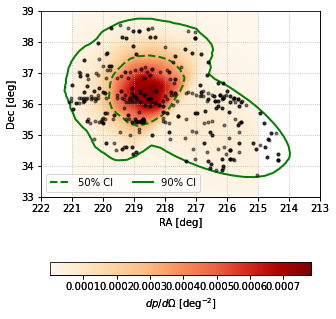

In [41]:
ra_list = [ra_sn, ra_agn]
dec_list = [dec_sn, dec_agn]
filename_suffix = ['SN', 'AGN']

for i in range(2):
    fig = plot_cartmap(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = ra_list[i], targ_dec = dec_list[i], angsize = 3)
    #fig = plt.figure()
    ax = fig.gca()
    ax.set(xlim=(222, 213), ylim=(33,39))
    plt.savefig(gw_name + '_alerce_' + filename_suffix[i] + '.png', dpi=120)

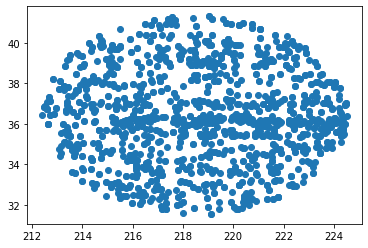

In [17]:
plt.scatter(alerts_ra, alerts_dec)
#hp.mollview(transient_pix_locs)
#twod_map = hp.mollview(gw_map, nest = True, rot = -110, cmap = "twilight", return_projected_map = True)
#print(twod_map.size)
#condition = np.isfinite(twod_map) #np.where(twod_map > 0.00000001) and np.isfinite(twod_map) #np.where(twod_map < 1000) # and twod_map < 10000)
#valid = np.extract(condition, twod_map)
#print(sum(twod_map[condition]))
#for i in twod_map[condition]:
#    if i > 0.0001:
#        print(i)

# Following the conventions here - https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr9.ipynb
npix = len(gw_map)
lev95, lev90 = compute_quantiles([0.95, 0.90], gw_map)#[0]
#print(lev90)
pixels = hp.ring2nest(gw_properties["nside"], np.arange(npix)) #np.arange(npix) 
pix95_2 = pixels[gw_map > lev95]
pix90_2 = pixels[gw_map > lev90]

#print(sum(gw_properties["prob"])) #[np.where(gw_properties["prob"] > 0.0001)]
#print(transient_pix_locs)

print(len(pix90))
print(len(pix90_2))
print(len(pix95))
print(len(pix95_2))

## Matching DESI observations to 95% contour

In [21]:
def decam_matching(target_ras_in = np.array([]), target_decs_in = np.array([]), ra_in = np.array([]), dec_in = np.array([]), 
                   max_sep = 2, sep_units = 'deg', query_dates = ""):
    
    if sep_units == 'arcsec':
        max_sep *= u.arcsec
    elif sep_units == 'arcmin':
        max_sep *= u.arcmin
    elif sep_units == 'deg':
        max_sep *= u.deg
    else:
        print("Separation unit specified is invalid for matching. Defaulting to arcsecond.")
        max_sep *= u.arcsec
        
    if not np.array(target_ras_in).size:
        return np.array([]), np.array([])
    
    nan_ra = np.isnan(target_ras_in)
    nan_dec = np.isnan(target_decs_in)
    
    if np.any(nan_ra) or np.any(nan_dec):
        print("NaNs found, removing them from array (not FITS) before match.")
        #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
        nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
        target_ras_in = target_ras_in[nans] # Logic masking, probably more efficient
        target_decs_in = target_decs_in[nans]
        #print("Reduced length (ra, dec):", len(target_ras), len(target_decs))
        #print(np.where(np.isnan(target_ras) == True))
        #print(target_ras[:100])
        #print(np.where(np.isnan(target_decs) == True))
        #target_ras = np.delete(target_ras, nans)
        #target_decs = np.delete(target_decs, nans)
    
    tree_name = "_".join(("kdtree", query_dates))
    
    coo_trans_search = SkyCoord(target_ras_in*u.deg, target_decs_in*u.deg)
    coo_alerts = SkyCoord(ra_in*u.deg, dec_in*u.deg)

    idx_alerts, d2d_trans, d3d_trans = match_coordinates_sky(coo_trans_search, coo_alerts)#, storekdtree = tree_name) # store tree to speed up subsequent results

    sep_constraint = d2d_trans < max_sep
    trans_matches = coo_trans_search[sep_constraint]
    alerts_matches = coo_alerts[idx_alerts[sep_constraint]]
    
    #if trans_matches.size:
        #sort_dist = np.sort(d2d_trans)
        #print("Minimum distance found: ", sort_dist[0])
        #print("5 closest (in case there's more than one): ", sort_dist[:5])
        #print()

    return trans_matches, alerts_matches

In [177]:
# From light_transient_matching, copy, pasted, and modified
def initial_check(skymap_ra_in, skymap_dec_in, sep_arcsecond = None): #(ledger_df = None, ledger_type = ''):
    
    db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
    #exposure_path = os.environ["DESI_SPECTRO_REDUX"]
    
    #for obsdate,tile_number in obsdates_tilenumbers:
        #redux = '/'.join([os.environ['DESI_SPECTRO_REDUX'], args.redux, 'tiles'])
        #prefix_in = '/'.join([redux, tile_number, obsdate])

    # previous_date_ranges: "20201130" - "20210302"
    query_date_start = "20201231" #"20210228"
    
    today = Time.now()
    smushed_YMD = today.iso.split(" ")[0].replace("-","")
    
    query_date_end = smushed_YMD 

    query2 = "PRAGMA table_info(exposures)"
    query3 = "PRAGMA table_info(tiles)"
    # Crossmatch across tiles and exposures to grab obsdate via tileid
    query_match = "SELECT distinct tilera, tiledec, obsdate, obsmjd, expid, program, exposures.tileid from exposures INNER JOIN tiles ON exposures.tileid = tiles.tileid where obsdate BETWEEN " + \
        query_date_start + " AND " + query_date_end + ";" #obsdate>20210228 
    #query_dates = "SELECT obsdate from exposures INNER JOIN tiles ON exposures.tileid = tiles.tileid where obsdate BETWEEN " + \
        #query_date_start + " AND " + query_date_end + ";"

    conn = sqlite3.connect(db_filename)

    conn.row_factory = sqlite3.Row # https://docs.python.org/3/library/sqlite3.html#sqlite3.Row

    cur = conn.cursor()
    
#     cur.execute(query2)
#     row2 = cur.fetchall()
#     for i in row2:
#         print(i[:])
    #cur.execute(query)
    #rows = cur.fetchall()

    cur.execute(query_match)
    matches_list = cur.fetchall()
    cur.close()

    # I knew there was a way! THANK YOU!
    # https://stackoverflow.com/questions/11276473/append-to-a-dict-of-lists-with-a-dict-comprehension
    date_dict = {k['obsdate'] : list(filter(lambda x:x['obsdate'] == k['obsdate'], matches_list)) for k in matches_list}

    #cur.execute(query_dates)
    #dates = set(cur.fetchall())

    desi_matches_dict = {} #{i['obsdate']: [] for i in matches_list}

    all_desi_matches = []
    all_confidence_matches = []
    
    #decam_transients = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/')
    #if ledger_type.upper() == 'DECAM_TAMU':
    #    if ledger_df.empty:
    #        ledger_df = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/')

    for date, row in date_dict.items():
        
        date_str = str(date)
        date_str = date_str[:4]+"-"+date_str[4:6]+"-"+date_str[6:] # Adding dashes for Time
        obs_mjd = Time(date_str).mjd

        # This method is *technically* safer than doing a double list comprehension with set albeit slower
        # The lists are small enough that speed shouldn't matter here
        unique_ra_dec = set([(i[0], i[1]) for i in row]) # there's probably a way to do this in SQL... oh well
        #print(unique_ra_dec)
        target_ras, target_decs = zip(*unique_ra_dec)
        
#         if ledger_type.upper() == 'ALERCE':
#             if ledger_df.empty:
#                 ledger_df = access_alerts(lastmjd=obs_mjd-28) # Modified Julian Day #.mjd
#         elif ledger_type.upper() == 'DECAM_TAMU':
#             pass
#         else:
#             print("Cannot use alerts broker/ledger provided. Stopping before match.")
#             return {}
        
        if sep_arcsecond:
            desi_matches, confidence_matches = decam_matching(target_ras_in = target_ras, target_decs_in = target_decs, 
                                                              ra_in = skymap_ra_in, dec_in = skymap_dec_in, 
                                                              query_dates = query_date_start + query_date_end, max_sep = sep_arcsecond)
        else:
            desi_matches, confidence_matches = decam_matching(target_ras_in = target_ras, target_decs_in = target_decs, 
                                                              ra_in = skymap_ra_in, dec_in = skymap_dec_in, 
                                                              query_dates = query_date_start + query_date_end)
        
        if desi_matches.size:
            #print(len(row))
            all_desi_matches.append(desi_matches)
            # To retrieve from SkyCoord into numpy float, x.ra.deg, x.dec.deg
            all_confidence_matches.extend(confidence_matches)
        else:
            continue

        desi_matches_dict[date] = []

        for tup in desi_matches:
            ra = tup.ra.deg
            dec = tup.dec.deg
            match_rows = [i for i in row if (i['tilera'], i['tiledec']) == (ra, dec)]
            desi_matches_dict[date].extend(match_rows)
            
    return desi_matches_dict, all_confidence_matches

In [24]:
# Using 95% confidence skymap
ra_95, dec_95 = hp.pix2ang(gw_properties["nside"], pix95, lonlat = True)

In [28]:
#desi_matches, confidence_matches = initial_check(ra_95, dec_95)
desi_matches, _ = initial_check(ra_95, dec_95)

In [165]:
# Borrowed from Segev's code, thanks Segev! 
# https://github.com/MatthewPortman/timedomain/blob/master/gwtarget/gw_dr9.ipynb

def build_targlist_table(nside, pix_map):
    hpdirnames = ['/global/project/projectdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright',
                  '/global/project/projectdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/dark']

    readcols = ['TARGETID', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID',
                'RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH',
                'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET',
                'FLUX_G', 'FLUX_R', 'FLUX_Z',
                'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z']

    targlist_threshold = None
    for hpdirname in hpdirnames:
        if targlist_threshold is None:
            targlist_threshold = Table(io.read_targets_in_hp(hpdirname, nside = nside, pixlist=pix_map, columns=readcols))
        else:
            targlist_threshold = vstack(targlist_threshold, Table(io.read_targets_in_hp(hpdirname, nside = nside, pixlist=pix_map, columns=readcols)))

    # targlist90.rename_column('BRICK_OBJID', 'OBJID')
    targlist_threshold = unique(targlist_threshold)
    
    return targlist_threshold

In [168]:
def targlist_write(table_in, filename, overwrite = True):
    # building the table takes *forever*
    # if overwrite = True, then overwrites regardless
    # if false, checks if the tables are equivalent and does nothing if they are
    # otherwise appends a 1 to the filename and writes
    # So if this were to happen a bunch you'd have xyz1111111.dat ;)
    
    if not overwrite:
        try:
            table_read = Table.read(filename)
        except:
            print("Can't find table specified per", filename)
            print("Writing a new one to", filename)
            overwrite = True

    if overwrite:
        table_in.write(filename)
    else:
        if setdiff(table_in, table_read): # If there are differences
            name, ext = filename.split('.')
            name += "1"
            table_in.write(".".join((name, ext)))
    
    return None

In [170]:
rebuild = False
write_new = False
overwrite = False
read_in = False

if rebuild:
    targlist95 = build_targlist_table(gw_properties["nside"], pix95)

if write_new:
    targlist_write(targlist95, 'targlist95_dr9_' + gw_name + '.ecsv', overwrite)
    
if read_in:
    targlist95 = Table.read('targlist95_dr9_' + gw_name + '.ecsv') # find a way to store pix threshold as meta data if you really want to be fancy ;)

In [199]:
m_dict, targlist_matches = initial_check(np.array(targlist95['RA']), np.array(targlist95['DEC']), sep_arcsecond = 1.0)

In [215]:
targlist_matches = SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_matches])), unit = 'deg')
tlist_matches_table = Table([targlist_matches.ra.deg, targlist_matches.dec.deg], names = ('RA', 'DEC'))

#print(Table(targlist_matches))
targlist_reduced = setdiff(targlist95['RA', 'DEC'], tlist_matches_table)

#print(len(targlist95))
#print(len(targlist_reduced))

assert len(targlist_reduced) == len(targlist95) - len(targlist_matches), "Something went wrong masking the dr9 target list! Stopping."
print('{:.2f}% of targets have already been observed within 1 arcsecond.'.format(len(targlist_reduced)/len(targlist95)))

1.00% of targets have already been observed within 1 arcsecond.


In [154]:
#print('tilera, tiledec, obsdate, obsmjd, expid, tileid')
tile_ras = []
tile_decs = []
program_info = []

for k,v in desi_matches.items():
    for i in v:
        if i['tilera'] not in tile_ras and (i['program'] == 'BRIGHT' or i['program'] == 'DARK'):
            print(i[:])
            tile_ras.append(i['tilera'])
            tile_decs.append(i['tiledec']) 
            program_info.append(i['program'])

#no_repeats = [(i, j, k) for i,j,k in zip(tile_ras, tile_decs, program_info) if ]
#tile_ras = list(set(tile_ras))
#tile_decs = list(set(tile_decs))
#print(tile_ras)

(217.889, 34.495, 20210405, 59310.234805512, 83535, 'BRIGHT', 201)
(252.639, 34.536, 20210406, 59311.415519393, 83740, 'DARK', 379)
(252.376, 34.563, 20210407, 59312.458721196, 83888, 'DARK', 380)
(217.655, 34.393, 20210407, 59312.320808641, 83875, 'DARK', 191)
(252.524, 34.382, 20210408, 59313.459575804, 83994, 'DARK', 381)
(252.518, 34.619, 20210409, 59314.38495279, 84115, 'DARK', 382)
(217.901, 34.314, 20210409, 59314.321635757, 84110, 'DARK', 192)
(217.732, 34.506, 20210410, 59315.304710501, 84230, 'DARK', 193)
(252.379, 34.433, 20210410, 59315.41992601, 84239, 'DARK', 383)
(252.64, 34.468, 20210411, 59316.465437826, 84423, 'DARK', 384)
(217.747, 34.288, 20210412, 59317.312443026, 84519, 'DARK', 194)
(252.593, 34.592, 20210412, 59317.452671331, 84532, 'DARK', 385)
(252.354, 34.498, 20210413, 59318.43797876, 84655, 'DARK', 386)
(217.937, 34.44, 20210413, 59318.488425866, 84660, 'DARK', 195)
(252.597, 34.411, 20210416, 59321.415568975, 85099, 'DARK', 387)
(252.437, 34.608, 20210417, 

In [23]:
# Borrowed from gw_skymap.py to be modified

def plot_cartmap_tiles(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None, program_names = None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')
    
    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        if program_names:
            
            bright_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if k == 'BRIGHT'])
            dark_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if k == 'DARK'])
            
            bright_dots = ax.plot(bright_pointing[:, 0], bright_pointing[:, 1], 'c.', alpha=0.5, label = 'BRIGHT') 
            dark_dots = ax.plot(dark_pointing[:, 0], dark_pointing[:, 1], 'm.', alpha=0.5, label = 'DARK') 
            
        else:
            ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5, label = 'Matches') # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    _h, _l = ax.get_legend_handles_labels()

    # Add DESI tile drawings, specified by central RA, Dec.
    if tile_ra is not None and tile_dec is not None:
        #for _ra_c, _dec_c in zip(tile_ra, tile_dec):
        for _ra_c, _dec_c in zip(targ_ra, targ_dec):
            circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
            ax.add_artist(circ)

        _h.append(circ)
        _l.append('DESI FOV')
    
    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

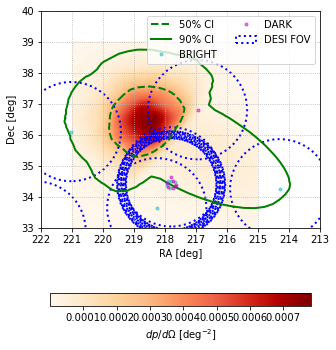

In [24]:
fig = plot_cartmap_tiles(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = tile_ras, targ_dec = tile_decs, angsize = 3, program_names = program_info)
ax = fig.gca()
ax.set(xlim=(222, 213), ylim=(33,40))
plt.savefig(gw_name + '_desi_tile-matches.png', dpi=120)

In [27]:
todayy = Time.now()
print(str(todayy).split(" ")[0])

2021-06-04
